# Fortune Medical Associates, Predicting Drug Review Results
**By Yamuna Umapathy**

## Business Understanding:

Our Stakeholder Fortune Medical Associates wants us to classify Positive & Negative ratings from given Patient's Drug Review results. We have to
find the best model which predicts patient's review has positive or negative effect after medication. 

## Dataset:

Dataset comes from UCI Machine Learning Respository, https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com. The dataset provides 
patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by online pharmaceutical review sites.

Dataset was cleaned, and has 215,000 rows and 6 important features to be used for our analysis. Features description as below:

`Unnamed0(ID)`: Patient's File/Medical ID in Medical office (numerical)

`drugName`    : Name of drug prescribed (categorical).

`condition`   : Patient's health condition (categorical).

`review`(text): Patient review after taking drug (categorical).

`rating`      : Patient's review rating after taking medication(float)

`date`        : Date of review entry (date)

`usefulCount` : Number of users who found review useful (numerical)

## Data Exploration & Cleaning:

In [1]:
# Importing all libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from copy import deepcopy
import pickle

import nltk
import string
import re
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag
from textblob import TextBlob

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay,roc_auc_score

import pyLDAvis
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import NMF 


In [2]:
# Opening our dataset through pandas

df_train = pd.read_csv("data/drugsComTrain_raw.tsv", delimiter='\t', encoding = 'utf-8')
df_train

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79


In [3]:
df_test = pd.read_csv("data/drugsComTest_raw.tsv", delimiter='\t', encoding = 'utf-8')
df_test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [4]:
# Concatenating our train & test datasets available from source to start EDA

df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
215058,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
215059,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
215060,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
215061,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


In [5]:
# renaming column Unnamed: 0 as ID
df = df.rename(columns = {'Unnamed: 0': 'ID'})
df.columns

Index(['ID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 11.5+ MB


In [7]:
# Checking for missingness

df.isna().sum()

ID                0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

Above shows column `condition` has 1194 missing values, since this is Medical field, not using Simple Imputer or other methods to fill in
info which may be risky later. Dropping rows which has missigness for `condition` which is one of the important feature in our analysis.

In [8]:
# dropping Nan's for column condition

df.dropna(subset = ['condition'], inplace=True)
df.isna().sum()

ID             0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [9]:
# checking unique values in each column except ID & review 

print(df['drugName'].value_counts(), "\n")
print(df['condition'].value_counts(), "\n")
print(df['rating'].value_counts(), "\n")
print(df['usefulCount'].value_counts())
print(df['review'][0])

drugName
Levonorgestrel                       4896
Etonogestrel                         4402
Ethinyl estradiol / norethindrone    3619
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2682
                                     ... 
Hemin                                   1
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Allergy DN PE                           1
Name: count, Length: 3667, dtype: int64 

condition
Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                    

In [50]:
# save cleaned file as csv
#df.to_csv("data/DrugReview.csv")
df.loc[df['condition']=='Depression']


,ID,drugName,condition,review,rating,date,usefulCount
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10.0,"March 9, 2017",54
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8.0,"May 7, 2011",3
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4.0,"April 27, 2016",3
67,131909,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10.0,"June 20, 2013",166
81,171349,Wellbutrin,Depression,"""Started taking it and I slept well at night a...",4.0,"January 13, 2017",15
...,...,...,...,...,...,...,...
214897,28837,Lexapro,Depression,"""Lexapro quickly lifted me out of depression a...",8.0,"October 27, 2009",12
214898,93103,Vortioxetine,Depression,"""When I started having Brintellix 10mg, nausea...",9.0,"May 1, 2016",64
214988,61639,Citalopram,Depression,"""Best medication ever I&#039;m on 20 mg .its v...",10.0,"July 22, 2016",43
215021,27561,Maprotiline,Depression,"""I have been taking maprotiline for over 35 ye...",9.0,"May 19, 2015",10


In [53]:
df['review'][81]

'"Started taking it and I slept well at night and awoke early around 5 to start my day happily. But come 8 am and I am drowsy and needed to take already two hrs nap. Awake and resume\r\r\nMy day with not much difficulties. Than st 2 pm again I needed  a nap? So how was I gonna make it to work and my appointments too ? I went cold turkey. Felt much better after that. Only to crash again. I did try other anti depressants including pristique. But I suffered with insomnia with these meds.  I know I need to start again but so confused if I should resume welbutrin"'

## Preprocessing:

**Target Variable `rating`**

Implementing TextPreprocessor calling class function, following cleaning process will be completed: Lowercasing, Tokenizing and removing
stopwords, Tagging POS and Lemmatizing. 

In [10]:
# class function for preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data, y = 0):
        return self

    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.process_doc)
        return normalized_corpus

    def process_doc(self, doc):
        lemm = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None
        normalized_doc = [token.lower() for token in word_tokenize(doc) if ((token.isalpha()) & (token not in stop_words))]
        tagged_tokens = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(normalized_doc)))
        normalized_doc = [lemm.lemmatize(token, pos) for token, pos in tagged_tokens if pos is not None]
        return " ".join(normalized_doc)
     

In [20]:
# Making a copy before Train Test Split data
df_med = df.copy()
df_med.head()

,ID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [21]:
# Classifying Target variable as 2 classes: positive_rating (6-10) & negative_rating(0-5)
df_med['rating'] = df_med['rating'].replace({1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0, 6.0:1, 7.0:1, 8.0:1, 9.0:1, 10.0:1})
df_med['rating'].value_counts()

rating
1.0    149963
0.0     63906
Name: count, dtype: int64

Target variable has class imbalance, positive rating 70% and negative rating 30%. Using down sampling method, and have class 0 and class 1 with
same size 50K.

In [22]:
# Downsampling method
pos_df = df_med[df_med['rating']==1]
neg_df = df_med[df_med['rating']==0]

sample_size = 50000
ds_pos_df = pos_df.sample(n=sample_size, random_state=42)
ds_neg_df = neg_df.sample(n=sample_size, random_state=42)


In [23]:
# merging 2 datasets
balanced_df = pd.concat([ds_pos_df, ds_neg_df])
balanced_df['rating'].value_counts()

rating
1.0    50000
0.0    50000
Name: count, dtype: int64

In [24]:
# Lowercasing columns drugName, condition
balanced_df['drugName'] = balanced_df['drugName'].str.lower()
balanced_df['condition'] = balanced_df['condition'].str.lower()
balanced_df['condition'].value_counts()

condition
birth control                   20104
depression                       5496
pain                             3538
anxiety                          3365
acne                             3292
                                ...  
oppositional defiant disorde        1
zollinger-ellison syndrome          1
gaucher disease                     1
acute promyelocytic leukemia        1
varicose veins                      1
Name: count, Length: 802, dtype: int64

In [25]:
balanced_df['review'][0:1]

26630    "My last medication Velafaxine stopped working...
Name: review, dtype: object

## Baseline Model with Random Forest Classifier:

In [16]:
# Train test split

X = balanced_df['review']
y= balanced_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000,), (30000,), (70000,), (30000,))

In [17]:
# preprocessing
lemm = TextPreprocessor()
X_train_trans = lemm.fit_transform(X_train)
X_test_trans = lemm.transform(X_test)

In [24]:
# creating pipeline
model1_pipe = Pipeline([('countvec', CountVectorizer(min_df=0.05, max_df=0.95)),
                   ('model',RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42))
                    ])

# initiating model
model1_pipe.fit(X_train_trans, y_train)

Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('model',
                 RandomForestClassifier(max_depth=3, random_state=42))])

In [25]:
# predicting on X_test
y_pred_model1 = model1_pipe.predict(X_test_trans)
print("Accuracy:", accuracy_score(y_pred_model1, y_test))
print("F1 Score:", f1_score(y_pred_model1, y_test))
print("Precision:", precision_score(y_pred_model1, y_test))
print("Recall:", recall_score(y_pred_model1, y_test))
print(classification_report(y_pred_model1, y_test))
      

Accuracy: 0.6551666666666667
F1 Score: 0.6500930153898191
Precision: 0.6406666666666667
Recall: 0.6598008925506351
              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66     15435
         1.0       0.64      0.66      0.65     14565

    accuracy                           0.66     30000
   macro avg       0.66      0.66      0.66     30000
weighted avg       0.66      0.66      0.66     30000



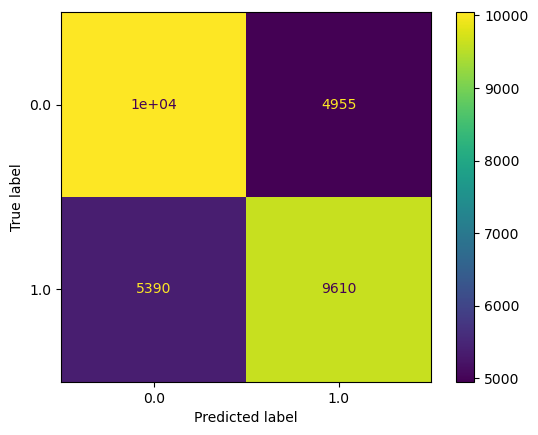

In [333]:
ConfusionMatrixDisplay.from_estimator(model1_pipe, X_test_trans, y_test);

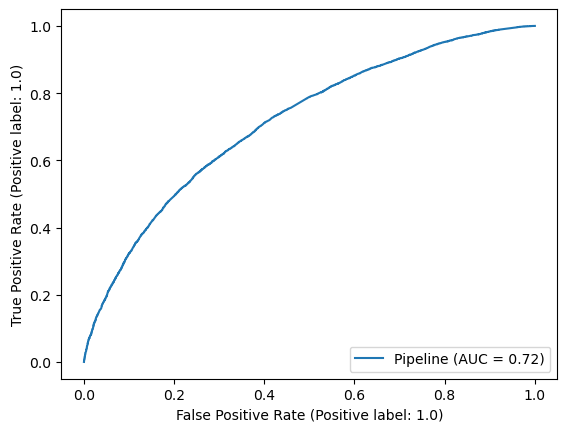

In [340]:
# ROC curve
RocCurveDisplay.from_estimator(model1_pipe, X_test_trans, y_test);

Baseline Model scored accuracy 66, and f1 score 65. We are using Accuracy as Metrics since dataset is balanced one. 

## RandomizedSearchCV with Hyperparameter Tuning:
**Random Forest Classifier**

To improve and get better results for our model, trying Hyperparameter Tuning through Randomized Search CV option. 

In [38]:
# parameter grid
params_rf = {'model__n_estimators': [10, 50, 100] ,
             'model__min_samples_leaf': [1,3,5],
            'model__max_depth': [3, 5, None]}



In [40]:
# initiating model
model2_pipe = Pipeline([('countvec', CountVectorizer(min_df=0.05, max_df=0.95)),
                      ('model', RandomForestClassifier(random_state=42))])
                    
# create randomizedsearch object for rf
random_search1 = RandomizedSearchCV(model2_pipe, params_rf, cv=5, scoring = 'accuracy', n_iter=10)

#Fit gridsearch to data
random_search1.fit(X_train_trans, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvec',
                                              CountVectorizer(max_df=0.95,
                                                              min_df=0.05)),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'model__max_depth': [3, 5, None],
                                        'model__min_samples_leaf': [1, 3, 5],
                                        'model__n_estimators': [10, 50, 100]},
                   scoring='accuracy')

In [41]:
random_search1.best_params_

{'model__n_estimators': 100,
 'model__min_samples_leaf': 1,
 'model__max_depth': None}

In [42]:
random_search1.best_score_

0.7639857142857143

In [44]:
# fitting with our best model
rf_bestmodel = random_search1.best_estimator_
rf_bestmodel.fit(X_train_trans, y_train)


Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('model', RandomForestClassifier(random_state=42))])

In [32]:
# Accuracy & classification report
y_pred_rf_rscv = rf_bestmodel.predict(X_test_trans)
print("Accuracy for Randomized Search with model RandomForest:", accuracy_score(y_test, y_pred_rf_rscv))
print("F1 Score for Randomized Search with model RandomForest:", f1_score(y_test, y_pred_rf_rscv))
print("Precision for Randomized Search with model RandomForest:", precision_score(y_test, y_pred_rf_rscv))
print("Recall for Randomized Search with model RandomForest:", recall_score(y_test, y_pred_rf_rscv))
print(classification_report(y_test, y_pred_rf_rscv))
      

Accuracy for Randomized Search with model RandomForest: 0.7627333333333334
F1 Score for Randomized Search with model RandomForest: 0.760948414830736
Precision for Randomized Search with model RandomForest: 0.7667162966973471
Recall for Randomized Search with model RandomForest: 0.7552666666666666
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76     15000
         1.0       0.77      0.76      0.76     15000

    accuracy                           0.76     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.76      0.76      0.76     30000



Random Forest with tuned hyper parameters {'model__n_estimators': 100,  'model__min_samples_leaf': 3 
 'model__max_depth': Non e}scored better accuracy score 76 than our Baseline model. Checking XGBoost Classifier next for better models.

**XGBoost Classifier**

In [230]:
# defining parameter grid
params_xg = {'model__n_estimators': [10, 50, 100],  
             'model__max_depth': [3, 5, None],  
             'model__min_child_weight': [2,3,5], 
             'model__learning_rate': [0.1, 0.2, 0.3] 
             }

# creating pipeline
model3_pipe = Pipeline([('countvec', CountVectorizer(min_df=0.05, max_df=0.95)),
                        ('model', XGBClassifier(random_state=42))
                       ])


In [231]:
# create randomizedsearch object for xgboost
random_search2 = RandomizedSearchCV(model3_pipe, params_xg, cv=5, scoring = 'accuracy', n_iter=12)

#Fit randomozedsearch to data
random_search2.fit(X_train_trans, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvec',
                                              CountVectorizer(max_df=0.95,
                                                              min_df=0.05)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            g...
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_iter=12,
                   param_distributions={'model__learning_rate': [0.1, 0.2, 0.3],
                                        'model__max_depth': [3, 5, None],
                                        'model__min_child_weight': [2, 3, 5],
                                        'model__n_estimators': [10, 50, 100]},
                   scoring='accuracy')

In [232]:
random_search2.best_params_

{'model__n_estimators': 100,
 'model__min_child_weight': 3,
 'model__max_depth': None,
 'model__learning_rate': 0.3}

In [233]:
random_search2.best_score_

0.7158000000000001

In [234]:
# Accuracy & classification report
xg_estimator = random_search2.best_estimator_
y_pred_xg_rscv = xg_estimator.predict(X_test_trans)
print("Accuracy for Randomized Search with model XGBoost:", accuracy_score(y_test, y_pred_xg_rscv))
print("F1 score for Randomized Search with model XGBoost:", f1_score(y_test, y_pred_xg_rscv))
print("Precision for Randomized Search with model XGBoost:", precision_score(y_test, y_pred_xg_rscv))
print("Recall for Randomized Search with model XGBoost:", recall_score(y_test, y_pred_xg_rscv))
print(classification_report(y_test, y_pred_xg_rscv))

Accuracy for Randomized Search with model XGBoost: 0.7152666666666667
F1 score for Randomized Search with model XGBoost: 0.7128160301237223
Precision for Randomized Search with model XGBoost: 0.7190043407487792
Recall for Randomized Search with model XGBoost: 0.7067333333333333
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72     15000
         1.0       0.72      0.71      0.71     15000

    accuracy                           0.72     30000
   macro avg       0.72      0.72      0.72     30000
weighted avg       0.72      0.72      0.72     30000



XGBoost with tuned hyper parameters scored accuracy score of 71, not good than our previous model score 76.

**Naive Bayes**

In [204]:
# defining parameter grid
params_nb = {'model__alpha': [0.1, 0.5, 1, 10],  
              'model__fit_prior':[True, False] }

# creating pipeline
model4_pipe = Pipeline([('countvec', CountVectorizer(min_df=0.05, max_df=0.95)),
                        ('model', MultinomialNB())
                       ])

In [205]:
# create randomizedsearch object for xgboost
grid_search3 = GridSearchCV(model4_pipe, params_nb, cv=5, scoring = 'accuracy')

#Fit randomozedsearch to data
grid_search3.fit(X_train_trans, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvec',
                                        CountVectorizer(max_df=0.95,
                                                        min_df=0.05)),
                                       ('model', MultinomialNB())]),
             param_grid={'model__alpha': [0.1, 0.5, 1, 10],
                         'model__fit_prior': [True, False]},
             scoring='accuracy')

In [206]:
grid_search3.best_estimator_

Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('model', MultinomialNB(alpha=0.5))])

In [207]:
grid_search3.best_score_

0.6706714285714286

In [208]:
# Accuracy & classification report
nb_estimator = grid_search3.best_estimator_
y_pred_nb_gcv = nb_estimator.predict(X_test_trans)
print("Accuracy for Randomized Search with model XGBoost:", accuracy_score(y_test, y_pred_nb_gcv))
print("F1 score for Randomized Search with model XGBoost:", f1_score(y_test, y_pred_nb_gcv))
print("Precision for Randomized Search with model XGBoost:", precision_score(y_test, y_pred_nb_gcv))
print("Recall for Randomized Search with model XGBoost:", recall_score(y_test, y_pred_nb_gcv))
print(classification_report(y_test, y_pred_nb_gcv))

Accuracy for Randomized Search with model XGBoost: 0.6617333333333333
F1 score for Randomized Search with model XGBoost: 0.6714156197383758
Precision for Randomized Search with model XGBoost: 0.6527323092420045
Recall for Randomized Search with model XGBoost: 0.6912
              precision    recall  f1-score   support

         0.0       0.67      0.63      0.65     15000
         1.0       0.65      0.69      0.67     15000

    accuracy                           0.66     30000
   macro avg       0.66      0.66      0.66     30000
weighted avg       0.66      0.66      0.66     30000



Naive Bayes scored the accuracy 66 same as our Baseline Model, Random Forest & XGBoost with randomized search option looks like the next better
models.

**Gradient Boosting**

In [66]:
# parameter grid
params_gb= {'model__min_samples_leaf': [5,10],
            'model__learning_rate':[0.1, 0.2, 0.5]
           }

In [67]:
# creating pipeline
model5_pipe = Pipeline([('countvec', CountVectorizer(min_df=0.05, max_df=0.95)),
                        ('model', GradientBoostingClassifier(n_estimators=100, max_depth=3))
                       ])

In [68]:
# create randomizedsearch object for grad boost
random_search4 = RandomizedSearchCV(model5_pipe, params_gb, cv=5, scoring = 'accuracy', n_iter=4)

#Fit randomozedsearch to data
random_search4.fit(X_train_trans, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvec',
                                              CountVectorizer(max_df=0.95,
                                                              min_df=0.05)),
                                             ('model',
                                              GradientBoostingClassifier())]),
                   n_iter=4,
                   param_distributions={'model__learning_rate': [0.1, 0.2, 0.5],
                                        'model__min_samples_leaf': [5, 10]},
                   scoring='accuracy')

In [69]:
random_search4.best_score_

0.6989285714285716

In [76]:
random_search4.best_params_

{'model__min_samples_leaf': 10, 'model__learning_rate': 0.5}

In [70]:
y_pred_gb = random_search4.predict(X_test_trans)
print("Accuracy for Randomized Search with Gradient Boost:", accuracy_score(y_test, y_pred_gb))
print("F1 Score for Randomized Search with Gradient Boost:", f1_score(y_test, y_pred_gb))
print("Precision for Randomized Search with Gradient Boost:", precision_score(y_test, y_pred_gb))
print("Recall for Randomized Search with Gradient Boost:", recall_score(y_test, y_pred_gb))

Accuracy for Randomized Search with Gradient Boost: 0.6974
F1 Score for Randomized Search with Gradient Boost: 0.6942404850117886
Precision for Randomized Search with Gradient Boost: 0.7015656909462219
Recall for Randomized Search with Gradient Boost: 0.6870666666666667


## Stacking:

Stacking is a learning technique that combines all Base models predictions, and meta-model takes the predictions from the base models as input features and learns how to weigh or combine them effectively.

In [27]:
balanced_df.head()

,ID,drugName,condition,review,rating,date,usefulCount
26630,225117,bupropion,bipolar disorde,"""My last medication Velafaxine stopped working...",1.0,"March 1, 2016",23
78003,131930,effexor xr,hot flashes,"""I had hot flashes every 2 hours. My face woul...",1.0,"April 1, 2012",157
93462,43061,phenytoin,seizures,"""This medication was prescribed to me as a 37 ...",1.0,"October 13, 2009",9
191644,189176,oxycodone,chronic pain,"""This drug works great""",1.0,"February 4, 2017",4
213309,206437,mesalamine,"ulcerative colitis, active","""I have found that it works great for my flare...",1.0,"July 19, 2009",8


In [28]:
# saving as csv to use for deploy
#balanced_df.to_csv("data/DrugReviews.csv")

Choose Random Forest Classifier as first model, XGBoost as second model and Naive Bayes as third model for our Base model's predictions for Stacking Classifier. And using Logistic Regression as Final estimator. 


In [29]:
# Train test split
X = balanced_df['review']
y= balanced_df['rating']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((70000,), (30000,), (70000,), (30000,))

In [30]:
# preprocessing II
stop_words = stopwords.words('english') 
class StemPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data, y = 0):
        return self

    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.stem_doc)
        return normalized_corpus
       
    def stem_doc(self, doc):
        stemmer = SnowballStemmer('english')
        lower_doc = [token.lower() for token in word_tokenize(doc) if token.isalpha()]
        filtered_doc = [token for token in lower_doc if token not in stop_words]
        stemmed_doc = [stemmer.stem(token) for token in filtered_doc]
        return " ".join(stemmed_doc)

In [31]:
# Stemming
stemm = StemPreprocessor()
X_train2_trans_stemm = stemm.fit_transform(X_train2)
X_test2_trans_stemm = stemm.transform(X_test2)

In [32]:
# stacking base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_depth=None)),
    ('xgb', XGBClassifier(n_estimators = 100, min_child_weight=2, max_depth=5, learning_rate=0.3)),
    ('nb', MultinomialNB(alpha=0.5))
    ]

# initiating meta model
sr = StackingClassifier(estimators, final_estimator = LogisticRegression(max_iter=1000))

In [33]:
#creating pipeline
stack_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', sr)])

# fitting meta model
stack_pipe.fit(X_train2_trans_stemm, y_train2)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model',
                 StackingClassifier(estimators=[('rf',
                                                 RandomForestClassifier(min_samples_leaf=3)),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               fea...
                                                               learning_rate=0.3,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=2,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)),
                                                ('nb',
                                                 MultinomialNB(alpha=0.5))],
                                    final_estimator=LogisticRegression(max_iter=1000)))])

In [34]:
# checking score
stack_pipe.score(X_test2_trans_stemm, y_test2)

0.8218

In [218]:
# checking accuracy score, dataset is balanced
y_pred_st = stack_pipe.predict(X_test2_trans_stemm)
print("Accuracy score for stacking model:", accuracy_score(y_pred_st, y_test2))
print("Classification Report:", classification_report(y_pred_st, y_test2))

Accuracy score for stacking model: 0.8225333333333333
Classification Report:               precision    recall  f1-score   support

         0.0       0.82      0.82      0.82     15020
         1.0       0.82      0.82      0.82     14980

    accuracy                           0.82     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.82      0.82      0.82     30000



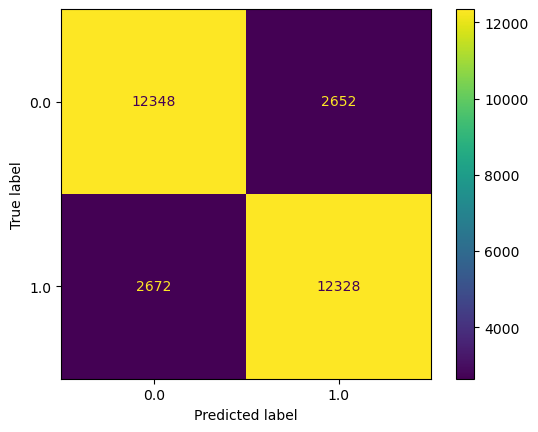

In [219]:
ConfusionMatrixDisplay.from_estimator(stack_pipe, X_test2_trans_stemm, y_test2);
plt.savefig("confusionmatrix_stmodel.png", dpi=300)

In [220]:
print("F1 score for stacking model:", f1_score(y_pred_st, y_test2))
print("Precision score for stacking model:", precision_score(y_pred_st, y_test2))
print("Recall score for stacking model:", recall_score(y_pred_st, y_test2))

F1 score for stacking model: 0.8224149432955303
Precision score for stacking model: 0.8218666666666666
Recall score for stacking model: 0.8229639519359145


Stacking model outperformed all models and scored best accuracy score 82.25. 

False Positive: Negative Reviews which was assigned under Positive reviews, means these patient needs follow up for appointment to diagnose why the                     medication failed to work.

False Negative: Positive reviews assigned under Negative reviews, means these patients are doing well after medication, and can contact doctor's office                   if has more questions.

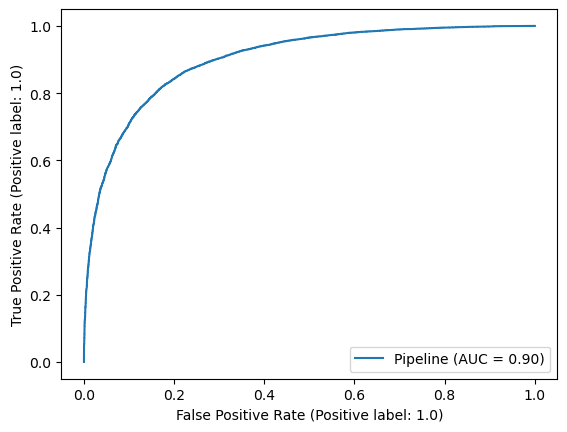

In [221]:
# ROC curve
RocCurveDisplay.from_estimator(stack_pipe, X_test2_trans_stemm, y_test2);

In [222]:
# Assuming you have a trained StackingClassifier named 'stack_pipe'
stack_clf = stack_pipe['model']  # Access the StackingClassifier model from the pipeline


In [223]:
# Access the base models
rf_model = stack_clf.named_estimators_['rf']

# Print feature importance for LogisticRegression
rf_feature_importance = rf_model.feature_importances_

# finding top15 features in rf
feat_imp_series = pd.Series(rf_feature_importance, index = feature_names).sort_values(ascending = False)
top_15_rf_features = feat_imp_series.head(15)
top_15_rf_features

great      0.014649
year       0.013946
wors       0.012323
love       0.012303
horribl    0.011096
worst      0.010508
stop       0.010264
life       0.010028
best       0.009830
work       0.009765
amaz       0.007522
never      0.006679
made       0.006635
effect     0.006574
bleed      0.006502
dtype: float64

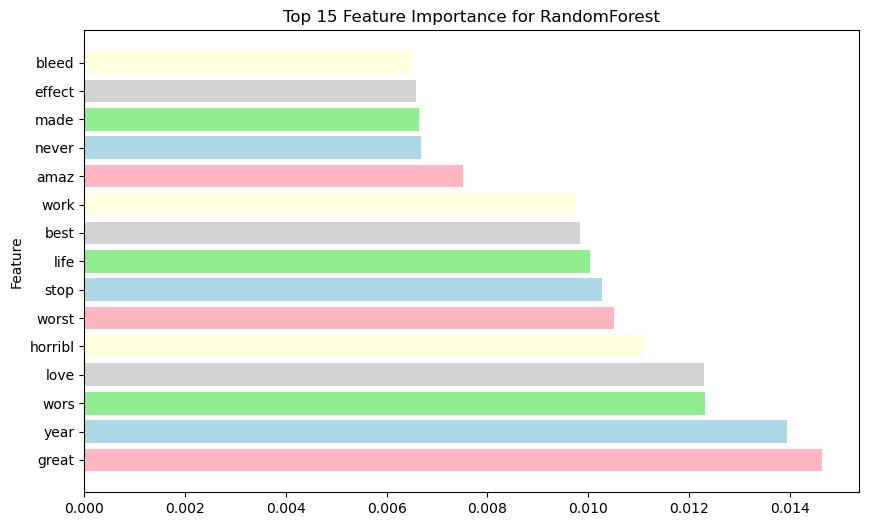

In [236]:
# Visualizing top 15 feature importance

plt.figure(figsize=(10, 6))
color_palette = ['lightpink', 'lightblue', 'lightgreen', 'lightgray', 'lightyellow']
plt.barh(top_15_rf_features.index, top_15_rf_features.values, color = color_palette)
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance for RandomForest')
plt.savefig("Top15Feature_Stmodel.png", dpi=300)
plt.show()

In [235]:
# Access xgb base model
xgb_model = stack_clf.named_estimators_['xgb']

# Print feature importance for xgb
xgb_feature_importance = xgb_model.feature_importances_

# finding top15 features in rf
feat_imp_series2 = pd.Series(xgb_feature_importance, index = feature_names).sort_values(ascending = False)
top_15_xgb_features = feat_imp_series2.head(15)
top_15_xgb_features

worst       0.015224
amaz        0.013450
wors        0.012787
call        0.012449
far         0.010893
horribl     0.010071
best        0.009070
great       0.008786
constant    0.008478
miracl      0.007779
thank       0.007402
terribl     0.007301
wast        0.007057
stop        0.006628
love        0.006245
dtype: float32

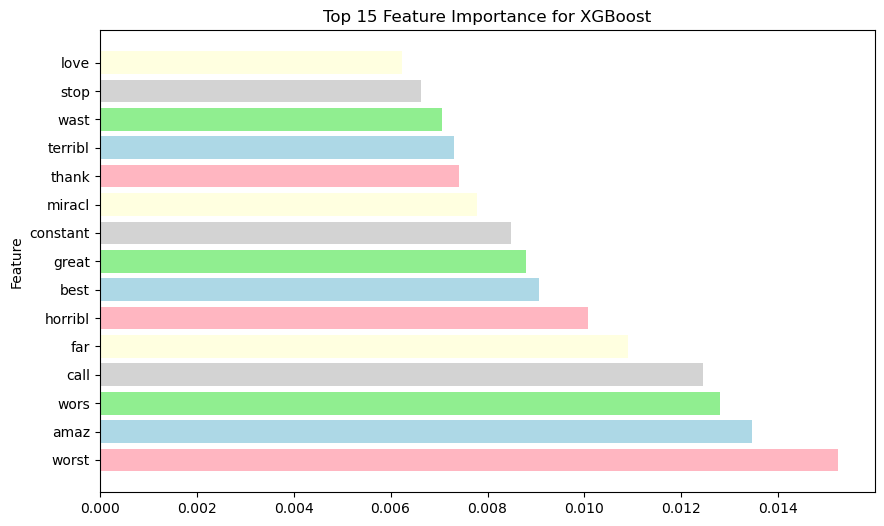

In [238]:
# Visualizing top 15 feature importance for XGB

plt.figure(figsize=(10, 6))
color_palette = ['lightpink', 'lightblue', 'lightgreen', 'lightgray', 'lightyellow']
plt.barh(top_15_xgb_features.index, top_15_xgb_features.values, color = color_palette)
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance for XGBoost')
plt.savefig("Top15Feature2_Stmodel.png", dpi=300)
plt.show()

Visualizing feature importance from Base models Random Forest & XGBoost. Naive Bayes worth noting not used for feature importance, Naive Bayes classifiers are based on the assumption of feature independence, meaning that each feature contributes independently to the probability of a certain class. We can examine the conditional probabilities of each feature given each class to understand which features have a stronger influence on the classification decision. Features with higher conditional probabilities for a particular class are considered more important for predicting that class. 

In [39]:
# Save the model
with open('FortuneMedical_Model.pkl', 'wb') as file:
    pickle.dump(stack_pipe, file)


In [37]:
# Save the model for vectorizer
with open('TfidfVectorizer.pkl', 'wb') as file:
    pickle.dump('tfidf', file)